In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from implementations import *
#from cross_validation import *

# Load the training data into feature matrix, class labels, and event ids:

In [2]:
import datetime
from proj1_helpers import *

DATA_TRAIN_PATH = 'data/train.csv' 
y, X, ids = load_csv_data(DATA_TRAIN_PATH)
X.shape

(250000, 30)

# Data Exploration

In [5]:
#handmade varaible containing the names of the columns of X, it might be usefull for us to compare datasets
feature_names=['DER_mass_MMC','DER_mass_transverse_met_lep','DER_mass_vis','DER_pt_h','DER_deltaeta_jet_jet','DER_mass_jet_jet','DER_prodeta_jet_jet','DER_deltar_tau_lep','DER_pt_tot','DER_sum_pt','DER_pt_ratio_lep_tau','DER_met_phi_centrality','DER_lep_eta_centrality','PRI_tau_pt','PRI_tau_eta','PRI_tau_phi','PRI_lep_pt','PRI_lep_eta','PRI_lep_phi','PRI_met','PRI_met_phi','PRI_met_sumet','PRI_jet_num','PRI_jet_leading_pt','PRI_jet_leading_eta','PRI_jet_leading_phi','PRI_jet_subleading_pt','PRI_jet_subleading_eta','PRI_jet_subleading_phi','PRI_jet_all_pt']

## Missing value ratio
let's first have a look a the number of missing values in each feature (columns) of our dataset. Features with a high ratio (#missing values/#values) are unlikely to carry much information 

In [6]:
def missing_values_r(v):
    'compute the missing values ratio for a given vector v'
    return 1-np.sum(v>-999)/len(v)

ratios={} #dictionary linkng a feature name with its missing values ratio
for feature_index in range(len(X[0])):
    ratios[feature_index]=missing_values_r(X[:,feature_index])
ratios   

{0: 0.15245600000000004,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.709828,
 5: 0.709828,
 6: 0.709828,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.709828,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.399652,
 24: 0.399652,
 25: 0.399652,
 26: 0.709828,
 27: 0.709828,
 28: 0.709828,
 29: 0.0}

[]

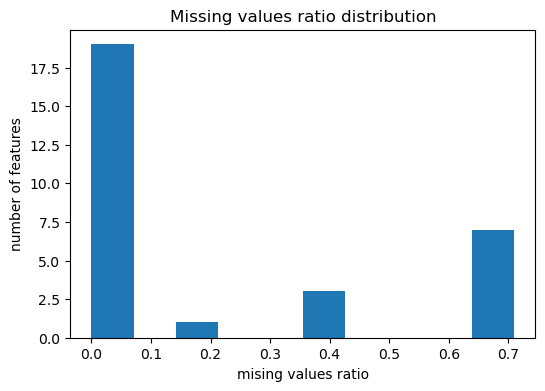

In [16]:
values = np.array(list(ratios.values()))

plt.style.use('default')
plt.figure(figsize=(6,4))
plt.hist(values)
plt.ylabel('number of features')
plt.xlabel('mising values ratio')
plt.title("Missing values ratio distribution")
plt.plot()

We imediatly see that the features of indices 4,5,6,26,27,28,12 have a 70 percent rate of missing values. We will probably discard them during the preprocessing process. 

In fact we can already discard them, thes is no use of keeping them during the Data exploration process. To remove the we simply use a threshold t that will be the upper bound on 'acceptable' missing values ration.

Note that t is an hyperparameter of our future model

In [17]:
#threshold
t=0.7
columns_to_delete=[]
for feature_index in ratios:
    if ratios[feature_index]>t:
        columns_to_delete.append(feature_index)
print(columns_to_delete)
X=np.delete(X,obj=columns_to_delete,axis=1)

#we also have to update the columns names since we removed some of them
feature_names=np.delete(feature_names,obj=columns_to_delete,axis=0)

[4, 5, 6, 12, 26, 27, 28]


In [6]:
X.shape

(250000, 23)

## Variance
In this section we study the variance of each feature, low variance features are unlikely to carry much information

In [112]:
stds=[]
for feature_index in range(np.shape(X)[1]):
    feature=min_max_scaler(X[:,feature_index])
    stds.append(np.std(feature))
stds

NameError: name 'min_max_scaler' is not defined

## Correlations
here we study the different correlations because...

In [9]:
def correlation(a,b):
    #since we want to measure linear correlation between features and target we will use the pearson corrlation provided in numpy 
    return np.corrcoef(a,b)[0][1]

#### Correlation Feature/Target
lets first check which features are correlated or not with the target vector 'y'. Uncorrelated features have no use to predict 'y'

In [10]:
correlations=[]

for feature_index in range(len(X[0])):
    #contains one feature of the dataset, namely one column of Tx
    feature=X[:,feature_index]
    
    #first of all we have to filter out all the values equal to -999 (unknown values)
    indices=feature>-999
    feature=feature[indices]
    target=y[indices]
    
    corr = correlation(feature,target)
    
    correlations.append(corr)

#### Mutual correlation between features 
Having a look at the mutual correlation between features is important because if two of them are highly correlated we could just use one and simplify the model

In [11]:
correlation_matrix=[]
for index1 in range(len(X[0])):
    correlations_row=[]#row of the correlation matrix
    for index2 in range(len(X[0])):
        #contains one feature of the dataset, namely one column of Tx
        feature1=X[:,index1]
        feature2=X[:,index2]

        #first of all we have to filter out all the values equal to -999 (unknown values)
        indices=(feature1>-999) * (feature2>-999)
        feature1=feature1[indices]
        feature2=feature2[indices]
        
        corr = correlation(feature1,feature2)
        
        correlations_row.append(corr)
    correlation_matrix.append(correlations_row)

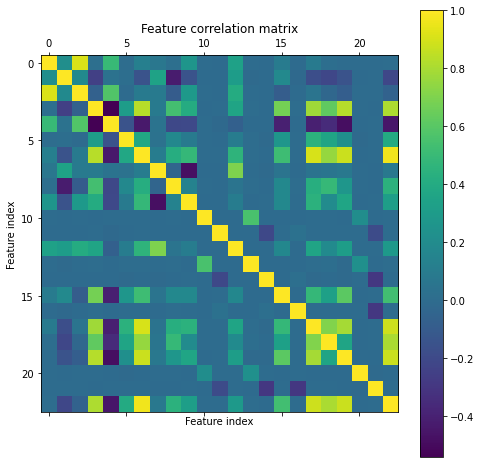

In [12]:
plt.figure(figsize=(8,8))
plt.matshow(correlation_matrix,fignum=1)
plt.colorbar()
plt.title("Feature correlation matrix")
plt.ylabel("Feature index")
plt.xlabel("Feature index")
plt.show()

In [13]:
threshold=0.8
features_to_delete=[]
for feature1_index in range(np.shape(correlation_matrix)[1]):
    for feature2_index in range(np.shape(correlation_matrix)[0]):
            corr=correlation_matrix[feature1_index][feature2_index]
            if np.abs(corr)>threshold and feature1_index>feature2_index:
                features_to_delete.append(feature2_index)

features_to_delete=np.unique(features_to_delete)
features_to_delete

array([ 0,  3,  6, 17, 18, 19])

In [14]:
X=np.delete(X,obj=features_to_delete,axis=1)

#we also have to update the columns names since we removed some of them
feature_names=np.delete(feature_names,obj=features_to_delete,axis=0)

We can see high values of correlation on the diagonal, these come from the auto-correlation of the features. The most interesting information that we see here is the others values that are close to one, these correspond to high correlations between two different features.

Note that the Feature correlation matrix is symetric 

## Correlations
In this section we will study the distributions (feature by feature) of the dataset. The result may help us to decide what to do with the missing values (-999) 

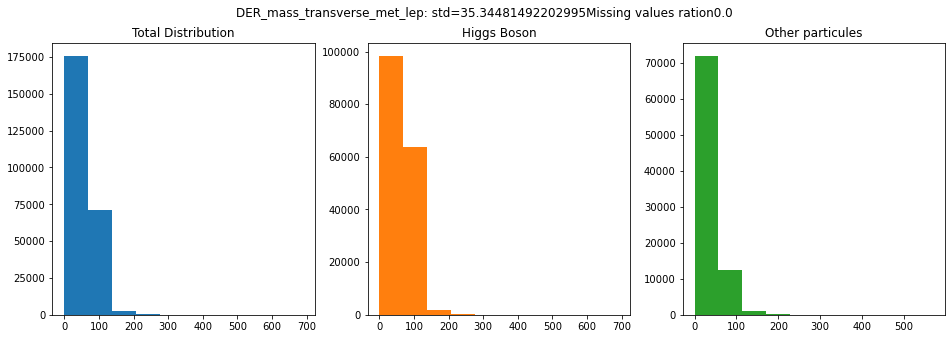

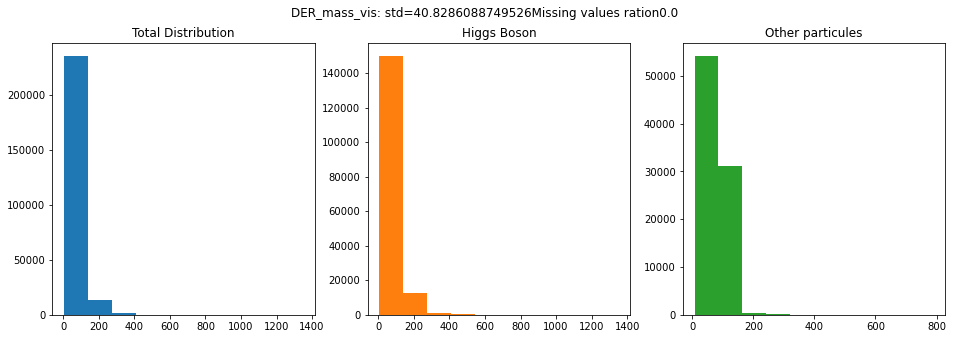

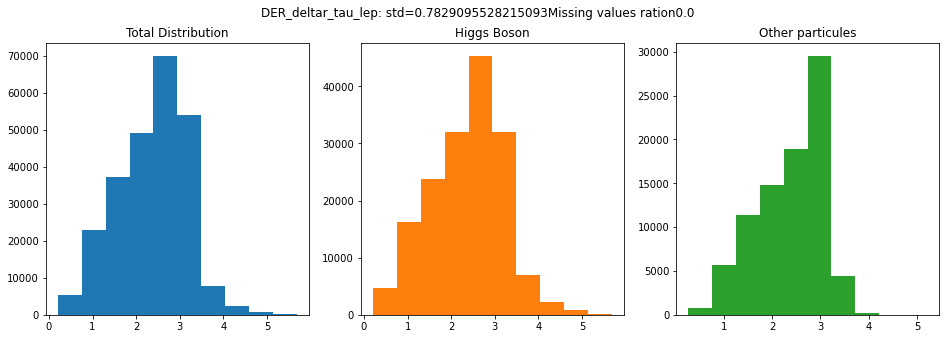

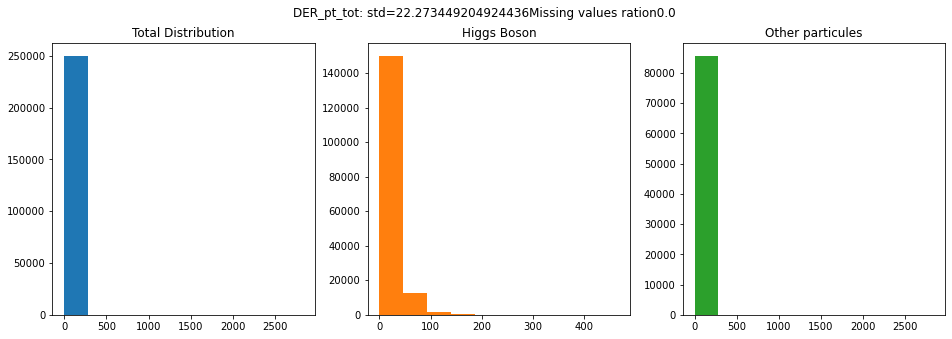

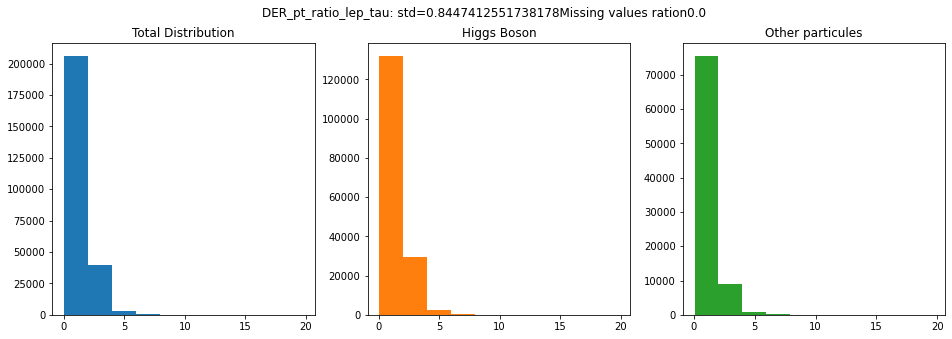

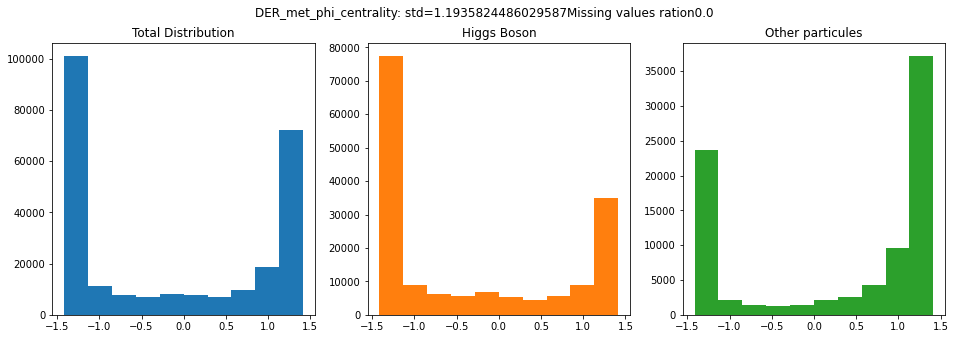

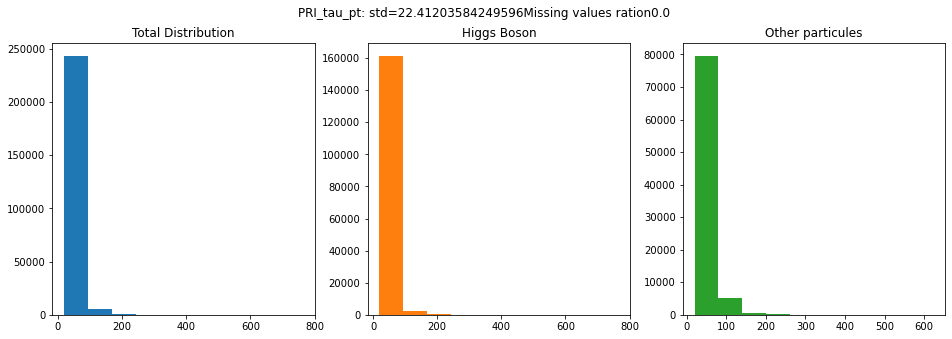

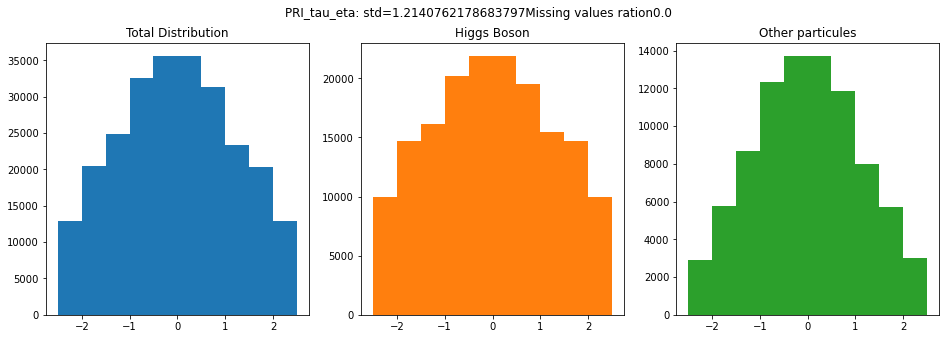

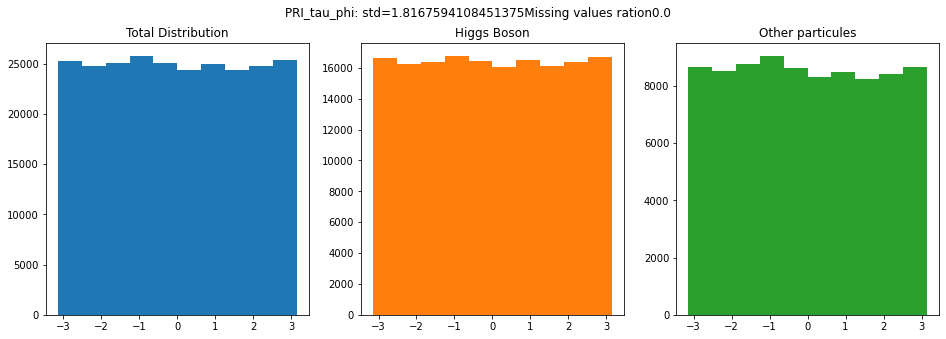

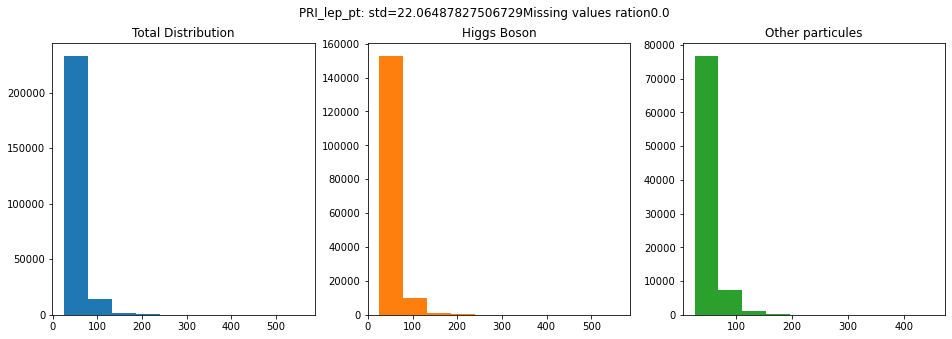

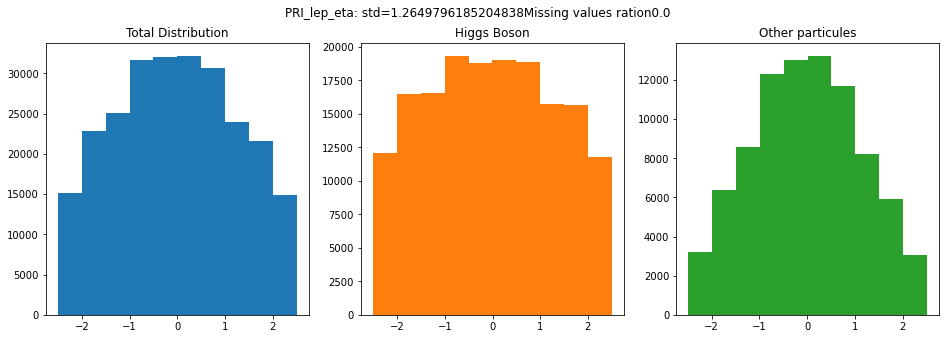

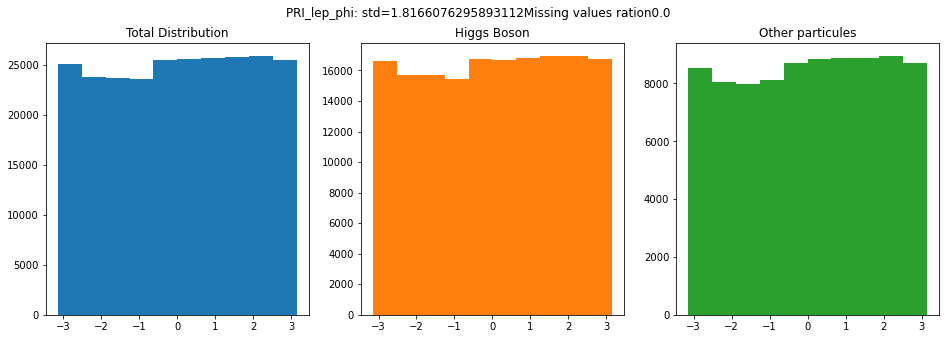

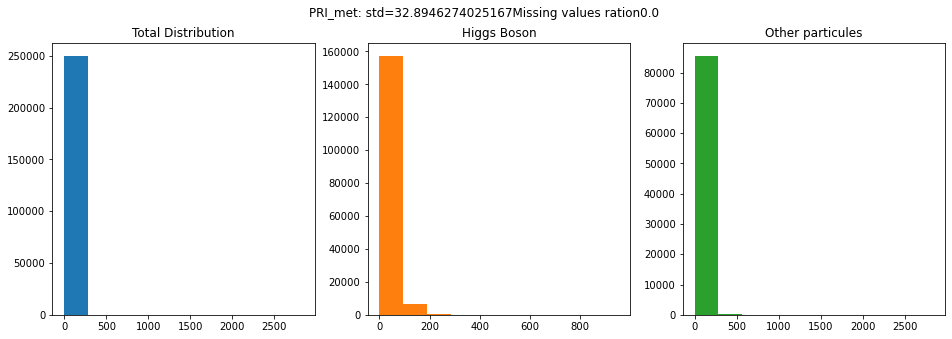

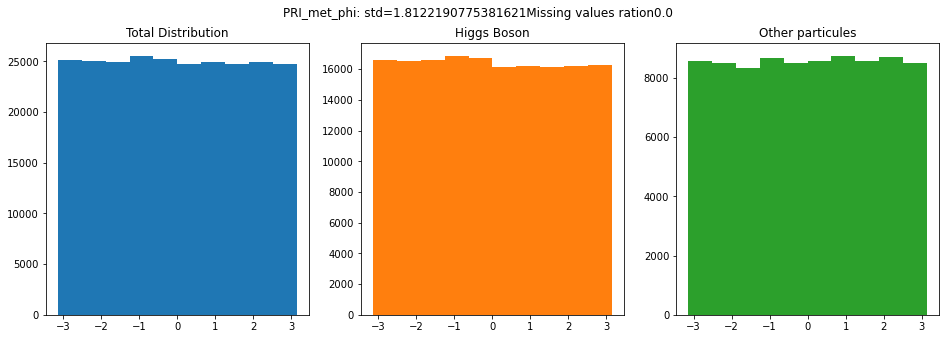

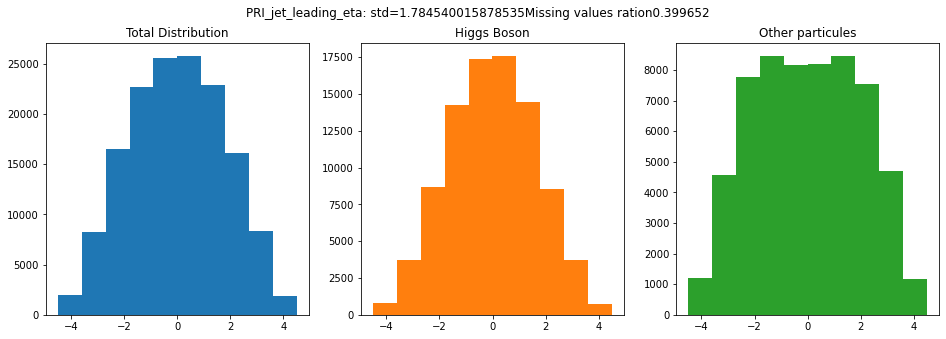

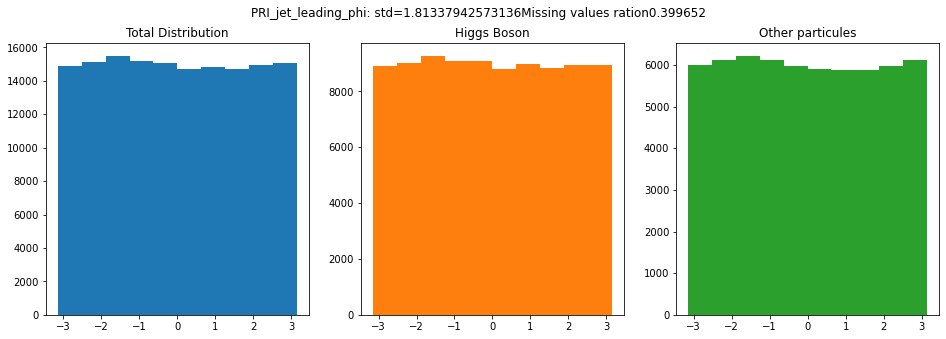

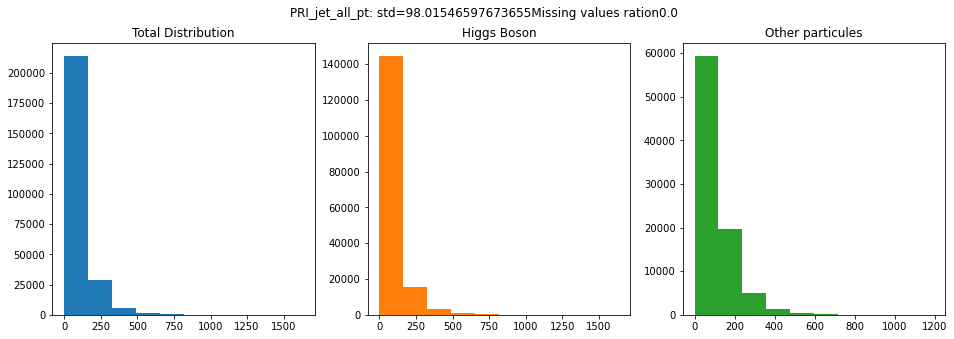

In [15]:
def plotHistogram(index, title,X,labels, filterMissingValues=True):
    extraCond = np.logical_or(np.full(labels.shape, not filterMissingValues, dtype=bool), (X[:,index]>-990))
    fig, axs = plt.subplots(1, 3,figsize=(16,5))
    axs[0].hist(X[extraCond,index])
    axs[0].set_title('Total Distribution')
    axs[1].hist(X[np.logical_and(labels==-1, extraCond),index], color='tab:orange')
    axs[1].set_title('Higgs Boson')
    axs[2].hist(X[np.logical_and(labels==1, extraCond),index], color='tab:green')
    axs[2].set_title('Other particules')
    fig.suptitle(title+ ": std="+ str(np.std(X[extraCond,index]))+"Missing values ration"+ str(missing_values_r(X[:,index])))

    #******************
    #plt.hist(X[:,index])
    plt.show()

for index in range(X.shape[1]):
    plotHistogram(index,feature_names[index],X,y)

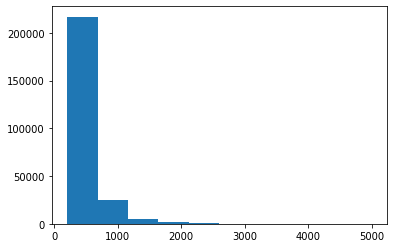

array([ True,  True,  True, ...,  True,  True,  True])

In [36]:
plt.hist(np.linalg.norm(X,axis=1))
plt.show()
outlier_mask=np.linalg.norm(X,axis=1)<800
outlier_mask


In [37]:
X=X[outlier_mask]


In [42]:
y=y[outlier_mask]

# Data preprocessing
## Feature reduction : Nans and Correlation

In [43]:
NAN_ENCODING = -999

In [44]:
#we set all the nan values to the mean of the corresponding feature
indices=np.all(X>NAN_ENCODING,axis=1)
filtered_dataset=X[indices]

means=np.mean(filtered_dataset,axis=0)

missing_values=X<-998
X[missing_values]=0
X=X+missing_values *means


In [88]:
X.shape

(227897, 30)

In [45]:
#indices of all data points that does'nt contain any values equal to -999 (unknown values)
non_nan_ind=np.all(X>NAN_ENCODING,axis=1)
#keep only non nans rows
X_t = X[non_nan_ind]
y_t = y[non_nan_ind]

## Train/Test set split

In [46]:
def train_test_split(X,y,train_ratio=0.67,seed=43):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    np.random.seed(seed)                # set seed
    N = X.shape[0]                      # number of data points 
    indices = np.arange(N)              # all row indices
    np.random.shuffle(indices)          # shuffle indices
    split_index=int(N*train_ratio)      # last training point 
    mask_tr = indices[:split_index]     # mask for training set
    mask_te = indices[split_index:]     # mask for testing set

    return X[mask_tr],y[mask_tr],X[mask_te],y[mask_te]

In [47]:
train_set,train_target,test_set,test_target = train_test_split(X_t,y_t,train_ratio=0.75)
print("train and test sets shape before expansion:",train_set.shape,test_set.shape)

train and test sets shape before expansion: (170922, 30) (56975, 30)


## Polynomial feature expansion

In [48]:
from build_polynomial import *
from Scaler import *

### Grid Search for the best $\lambda$ and the best degree

In [50]:
degrees = np.arange(5,8)
lambdas = np.logspace(-4, -3, 100)

rmse_tr = []
rmse_te = []

best_lambda, best_degree, best_acc = 0, 0, 0
best_poly_exp = None
best_weights  = None


#interractions_tr=interaction(train_set)
#interractions_te=interaction(test_set)
#**************
i  =0
#**************
for degree in degrees:
    expanser = PolynomialExpansion(degree)  # create object for polynomial expansion
    x_tr = expanser.expand(train_set)       # expand the training set
    x_te = expanser.expand(test_set)        # expand the test set
    
    #x_tr=np.concatenate([x_tr,interractions_tr],axis=1)
    #x_te=np.concatenate([x_te,interractions_te],axis=1)
    

    
    y_tr = train_target                     # renaming for consistency
    y_te = test_target                      # renaming for consistency
    for ind, lambda_ in enumerate(lambdas):
        weights, mse_tr = ridge_regression(y_tr,x_tr,lambda_)   # ridge regression with a given lambda
        mse_te = compute_loss(y_te,x_te,weights)                # compute loss on test set
        
        rmse_tr.append(np.sqrt(2*mse_tr))
        rmse_te.append(np.sqrt(2*mse_te))
        
        
        current_acc=evaluate_model(x_te,y_te,weights, print_=False)
        #we select the best set of hyperparameters based on the accuracy score
        if best_acc < current_acc:  # if a better parameters are found : update 
            best_lambda, best_degree, best_acc = lambda_, degree, current_acc
            best_poly_exp = expanser
            best_weights=weights
        
        # ***************************************************
        if (i%10)==0:
            print("degree={d}, lambda={l:.5f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format( d=degree, l=lambda_, tr=rmse_tr[-1], te=rmse_te[-1]))
        i = i+1
        
        
rmse_tr = np.asarray(rmse_tr).reshape((len(lambdas), len(degrees)))
rmse_te = np.asarray(rmse_te).reshape((len(lambdas), len(degrees)))
print("=====================================")
print(best_acc)

degree=5, lambda=0.00010, Training RMSE=0.762, Testing RMSE=0.761
degree=5, lambda=0.00013, Training RMSE=0.762, Testing RMSE=0.761
degree=5, lambda=0.00016, Training RMSE=0.762, Testing RMSE=0.761
degree=5, lambda=0.00020, Training RMSE=0.762, Testing RMSE=0.761
degree=5, lambda=0.00025, Training RMSE=0.762, Testing RMSE=0.761
degree=5, lambda=0.00032, Training RMSE=0.762, Testing RMSE=0.761
degree=5, lambda=0.00040, Training RMSE=0.762, Testing RMSE=0.761
degree=5, lambda=0.00051, Training RMSE=0.762, Testing RMSE=0.761
degree=5, lambda=0.00064, Training RMSE=0.762, Testing RMSE=0.761
degree=5, lambda=0.00081, Training RMSE=0.762, Testing RMSE=0.761
degree=6, lambda=0.00010, Training RMSE=0.751, Testing RMSE=0.751
degree=6, lambda=0.00013, Training RMSE=0.751, Testing RMSE=0.751
degree=6, lambda=0.00016, Training RMSE=0.751, Testing RMSE=0.751
degree=6, lambda=0.00020, Training RMSE=0.751, Testing RMSE=0.751
degree=6, lambda=0.00025, Training RMSE=0.751, Testing RMSE=0.751
degree=6, 

# Cross Validation


In [58]:
from cross_validation import grid_search_cv

degrees = np.arange(5,7)
lambdas = np.logspace(-4, -2, 20)
params={'degree':degrees,'lambda':lambdas}
#call to the grid search function
best_param = grid_search_cv(params,X,y,k_fold=10)

Evaluated for {'degree': 5, 'lambda': 0.0001} : loss = 0.7626278684549573
Evaluated for {'degree': 5, 'lambda': 0.00012742749857031334} : loss = 0.7626278502635696
Evaluated for {'degree': 5, 'lambda': 0.0001623776739188721} : loss = 0.762627831905674
Evaluated for {'degree': 5, 'lambda': 0.00020691380811147902} : loss = 0.7626278123800792
Evaluated for {'degree': 5, 'lambda': 0.00026366508987303583} : loss = 0.7626277906104483
Evaluated for {'degree': 5, 'lambda': 0.0003359818286283781} : loss = 0.7626277653996246
Evaluated for {'degree': 5, 'lambda': 0.00042813323987193956} : loss = 0.7626277353805744
Evaluated for {'degree': 5, 'lambda': 0.000545559478116852} : loss = 0.7626276989636973
Evaluated for {'degree': 5, 'lambda': 0.0006951927961775605} : loss = 0.762627654286524
Evaluated for {'degree': 5, 'lambda': 0.0008858667904100823} : loss = 0.7626275991714804
Evaluated for {'degree': 5, 'lambda': 0.0011288378916846883} : loss = 0.762627531104535
Evaluated for {'degree': 5, 'lambda'

{'degree': 6, 'lambda': 0.0001}

In [77]:
best_degree=best_param['degree']
best_lambda=best_param['lambda']
best_expanser = PolynomialExpansion(best_degree,with_scaler=False)
train_set_expanded=best_expanser.expand(train_set)

best_scaler = StandardScaler(has_bias=True)
train_set=best_scaler.fit(train_set_expanded)

best_weights,loss_tr = ridge_regression(y,train_set_expanded,best_lambda)

In [78]:
def predict(X,weights,scaler,expanser):
    X_expanded=expanser.expand(X)
    X_scaled=scaler.transform(X_expanded)
    
    return predict_labels(weights,X_scaled)


In [79]:
pred=predict(X,best_weights,best_scaler,best_expanser)

# Model evaluation

In [51]:
def evaluate_model(x,y,w, print_=False):
    pred=predict_labels(w, x)
    false_positive=np.sum(pred>y)
    false_negative=np.sum(pred<y)
    true_positive=np.sum((pred==y) * (y==np.ones(len(y))*1))
    true_negative=np.sum((pred==y) * (y==np.ones(len(y))*-1))
    confusion_matrix=[[true_positive,false_positive],[false_negative,true_negative]]
    if print_:
        print("==============================")
        print('precision=',true_positive/(true_positive+false_positive))
        print('accuracy=',(true_positive+true_negative)/len(pred))
        print('recall=',true_positive/(true_positive+false_negative))
        print('f1=',true_positive/(true_positive+0.5*(false_negative+false_positive)))
        print("confusion matrix:")
        print(confusion_matrix[0])
        print(confusion_matrix[1])
        print("==============================")   
    
    return (true_positive+true_negative)/len(pred)

In [ ]:
def predict(X,weights, param):
    degree=param['degree']
    

In [53]:
#interractions_te=interaction(test_set)
x_te = best_poly_exp.expand(test_set)
#x_te=np.concatenate([x_te,interractions_te],axis=1)
y_te = test_target
evaluate_model(x_te,y_te,best_weights, True)

precision= 0.7354693084205907
accuracy= 0.8124791575252304
recall= 0.6446826051112943
f1= 0.6870899718837863
confusion matrix:
[11730, 4219]
[6465, 34561]


0.8124791575252304

In [54]:
best_lambda

0.00014174741629268049

In [212]:
best_degree

7

In [213]:
def plot_heat_map(x, xticks, yticks, title):
    fig,ax = plt.subplots(figsize = (9, 9))
    im = ax.imshow(x)
    ax.set_xticklabels(xticks)
    ax.set_yticklabels(np.round(yticks, 6))
    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

[0.0001     0.00010235 0.00010476 0.00010723 0.00010975 0.00011233
 0.00011498 0.00011768 0.00012045 0.00012328 0.00012619 0.00012915
 0.00013219 0.0001353  0.00013849 0.00014175 0.00014508 0.0001485
 0.00015199 0.00015557 0.00015923 0.00016298 0.00016681 0.00017074
 0.00017475 0.00017886 0.00018307 0.00018738 0.00019179 0.0001963
 0.00020092 0.00020565 0.00021049 0.00021544 0.00022051 0.0002257
 0.00023101 0.00023645 0.00024201 0.00024771 0.00025354 0.0002595
 0.00026561 0.00027186 0.00027826 0.0002848  0.00029151 0.00029836
 0.00030539 0.00031257 0.00031993 0.00032745 0.00033516 0.00034305
 0.00035112 0.00035938 0.00036784 0.00037649 0.00038535 0.00039442
 0.0004037  0.0004132  0.00042292 0.00043288 0.00044306 0.00045349
 0.00046416 0.00047508 0.00048626 0.0004977  0.00050941 0.0005214
 0.00053367 0.00054623 0.00055908 0.00057224 0.0005857  0.00059948
 0.00061359 0.00062803 0.00064281 0.00065793 0.00067342 0.00068926
 0.00070548 0.00072208 0.00073907 0.00075646 0.00077426 0.00079248


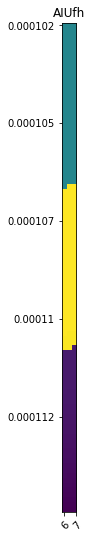

In [214]:
print(lambdas)
plot_heat_map(rmse_te, degrees, lambdas, "AIUfh")

# Generate predictions and save ouput in csv format for submission:

In [82]:
DATA_TEST_PATH = 'data/test.csv' # TODO: download train data and supply path here 
y_submission, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test.shape

(568238, 30)

In [84]:
#submission_set=np.delete(tX_test,obj=columns_to_delete,axis=1)
submission_set=tX_test

In [85]:
indices=np.all(submission_set>-999,axis=1)
filtered_dataset=submission_set[indices]

means=np.mean(filtered_dataset,axis=0)

missing_values=submission_set<-998
submission_set[missing_values]=0
submission_set=submission_set+missing_values *means

In [86]:
y_pred = predict(submission_set,best_weights,best_scaler,best_expanser)
np.sum(y_pred)/len(y_pred)

-0.6458279805292853

In [87]:
OUTPUT_PATH = 'data/submission.csv' # TODO: fill in desired name of output file for submission

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [164]:
########################################################

In [61]:
from cross_validation import *
for p in ParameterGrid({'a':[0,1,2],'b':[True,False],'c':['m','n','p','q']}).generate():
    print(p)

{'a': 0, 'b': True, 'c': 'm'}
{'a': 0, 'b': True, 'c': 'n'}
{'a': 0, 'b': True, 'c': 'p'}
{'a': 0, 'b': True, 'c': 'q'}
{'a': 0, 'b': False, 'c': 'm'}
{'a': 0, 'b': False, 'c': 'n'}
{'a': 0, 'b': False, 'c': 'p'}
{'a': 0, 'b': False, 'c': 'q'}
{'a': 1, 'b': True, 'c': 'm'}
{'a': 1, 'b': True, 'c': 'n'}
{'a': 1, 'b': True, 'c': 'p'}
{'a': 1, 'b': True, 'c': 'q'}
{'a': 1, 'b': False, 'c': 'm'}
{'a': 1, 'b': False, 'c': 'n'}
{'a': 1, 'b': False, 'c': 'p'}
{'a': 1, 'b': False, 'c': 'q'}
{'a': 2, 'b': True, 'c': 'm'}
{'a': 2, 'b': True, 'c': 'n'}
{'a': 2, 'b': True, 'c': 'p'}
{'a': 2, 'b': True, 'c': 'q'}
{'a': 2, 'b': False, 'c': 'm'}
{'a': 2, 'b': False, 'c': 'n'}
{'a': 2, 'b': False, 'c': 'p'}
{'a': 2, 'b': False, 'c': 'q'}
